### This notebook works with dog-project conda env that is installed with 

https://github.com/parksoy/Soyoung_Udacity_ND_DeepLearning/blob/master/3.Convolutional_networks/7_dog-project/requirements/dog-linux-gpu.yml

in AWS, deep learning AMI with source code, ubuntu, CUDA8. N. Virginia server was chosen.

In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
# Check for a GPU
import tensorflow as tf
print(tf.test.gpu_device_name())

/gpu:0


In [13]:
%%bash
pwd

/home/ubuntu/Soyoung_Udacity_ND_DeepLearning/5.Generative_Adversarial_Networks/3_face_generation


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

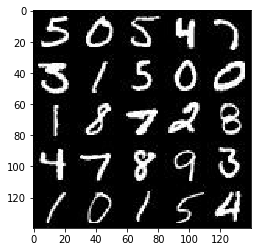

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

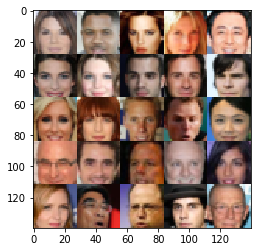

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32, name='learning_rate')  

    return  inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

### reviewer#1 

#### Discriminator  
1) Leaky ReLU activation function helps with the gradient flow and alleviate the problem of sparse gradients (almost 0 gradients). Max pooling generates sparse gradients, which affects the stability of GAN training. That’s the reason, you chose not to use pooling.

2) You have used batch normalization to stabilize GAN training by reducing internal covariant shift. You can go to this link[http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html] for further understanding Batch norm.

3) You have used Sigmoid as the activation function for the output layer which produces probability-like values between 0 and 1.

Improvement to make:
<font color='red'>
1) Use custom weight initialization. For example Xavier weight initialization to help converge faster by breaking symmetry or you can also use truncated_normal_initializer with stddev=0.02, which improve overall generated image quality, like in DCGAN paper.  

2) Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.  
 
3) Experiment with dropout layers for discriminator, applying dropout will decrease hyper learning distrib. If discriminator end up dominating generator, we must reduce discriminator learning rate and increase dropout.   
</font>  


Ref: F. Chollet, "Deep Learning with Python" chapt 8.32".   

Use: 

```
dp_layer = tf.nn.dropout(l_relu_output, keep_prob =0.8) or 
dp_layer = tf.layer.dropout(l_relu_output, rate =0.2)
```

In [19]:
#https://discussions.udacity.com/t/discriminator-variable-scope-reuse/662468

depth = 64 #==filters=the dimensionality of the output space(i.e. the number of filters in the convolution).
kernel_size=5 # kernel_size=height and width of the 2D convolution window
strides=2
alpha=0.06 #if this is not within this variable_scope, can not pass test: assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True)
#tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)
#Reviewer#1: Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.
        
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse) :
        
       
        # Hidden layer #1: Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, filters=depth, kernel_size = kernel_size, strides=strides, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * h1, h1)
        relu1_dropout = tf.nn.dropout(relu1, keep_prob =0.8)
        # 14x14x64 now
        
        # Hidden layer #2: 
        h2 = tf.layers.conv2d(relu1_dropout, filters=depth*2, kernel_size = kernel_size, strides=strides, padding='same',\
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2_dropout = tf.nn.dropout(relu2, keep_prob =0.8)
        # 7x7x128 now
        
        # Hidden layer #3: 
        h3 = tf.layers.conv2d(relu2, filters=depth*4, kernel_size = kernel_size, strides=strides, padding='same',\
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3_dropout = tf.nn.dropout(relu3, keep_prob =0.8)
        # 3x3x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*depth*4))
        logits = tf.layers.dense(flat, 1)
        isFakeReal = tf.nn.sigmoid(logits)
        
        return isFakeReal, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

### Reviewer#1

#### Generator  

You have used Tanh as the last layer of the generator output, so you will normalize the input images to be between -1 and 1 in train function.

You have met the basic requirements, but I recommend you to work on the below tips and comment on the improvements you see in the generated image.

<font color='red'>  
    
1) Experiment with more conv2d_transpose layers in generator block so that there're enough parameters in the network to learn the concepts of the input images. **DCGAN models produce better results when generator is bigger than discriminator.**  

Suggestion: 1024->512->256->128->out_channel_dim (Use stride as 1 to increase the number of layers without changing the size of the output image).   ==> instead, first input depth is increased from 1024 to 2048

2) Experiment with different slope values for leaky_relu as told in discriminator.  

3) Experiment dropout in generator, so that it is less prone to learning the data distribution and avoid generating images that look like noise.   

(CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC)  
</font>

In [20]:
import math
z=100
int(math.sqrt(z))

10

In [21]:

reshape_d=5


def generator(z, out_channel_dim,  is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        #Using the reverse process of the discriminator
        
        # First fully connected layer #1:
        h1 = tf.layers.dense(z, reshape_d*reshape_d*1024) # First fully connected layer, 256
        #(?, 256) now
        
        #Input to reshape is a tensor with z*56 values, but the requested shape requires a multiple of reshape_d**2 * 1024
        #Input to reshape is a tensor with 8192 values, but the requested shape requires a multiple of 25600
        
        print("z=", z)
        
        h1 = tf.reshape(h1, (-1, reshape_d, reshape_d, 1024))  #this 1024 is my choice upon paper. reshape_d comes from     
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1_dropout = tf.nn.dropout(h1, keep_prob =0.8)
        #(?, 7,7,1024) now
        
        # Hidden layer #2:
        h2 = tf.layers.conv2d_transpose(h1_dropout, 512, kernel_size = kernel_size, \
                                        strides=2, padding='same', \
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h2 (?, , , 512)=", h2.get_shape()) 
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2_dropout = tf.nn.dropout(h2, keep_prob =0.8)
        #(?, 7, 7, 512)    
        
        # Hidden layer #3:
        h3 = tf.layers.conv2d_transpose(h2_dropout, 256, kernel_size = kernel_size, \
                                        strides=2, padding='same', \
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h3 (?, , , 256)=", h3.get_shape()) #
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3_dropout = tf.nn.dropout(h3, keep_prob =0.8)
        #(?, 7, 7, 256)
        
        # Hidden layer #4:
        h4 = tf.layers.conv2d_transpose(h3_dropout, 128, kernel_size = kernel_size, \
                                        strides=1, padding='valid',\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h4 (?, , , 128)=", h4.get_shape()) 
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha * h4, h4)
        h4_dropout = tf.nn.dropout(h4, keep_prob =0.8)
        #(?, 14, 14, 128)
        

        #final layer #5:
        logits = tf.layers.conv2d_transpose(h4_dropout, out_channel_dim, kernel_size = kernel_size, \
                                            strides=1, padding='valid',\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("out_channel_dim=",out_channel_dim)
        print("logits (?, 28, 28, 5) =", logits.get_shape()) 
        fake_image = tf.tanh(logits)
        #(?, 28, 28, 5)
        
    return fake_image

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

z= Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 5
logits (?, 28, 28, 5) = (?, 28, 28, 5)
z= Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 5
logits (?, 28, 28, 5) = (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Reviewer #1

<font color='red'>    
Experiment with label smoothing for discriminator loss, it prevents discriminator from being too strong and to   generalize in a better way.    
</font>
Refer https://arxiv.org/abs/1606.03498

Below is a starter code,   
 
```python
d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
```

In [22]:
smooth=0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    #label smoothing for discriminator loss, it prevents discriminator from being too strong 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

z= Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 4
logits (?, 28, 28, 5) = (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

### Reviewer #1 

<font color='red'>    
To avoid internal covariant shift during training, you use batch norm. But in tensorflow **when is_train is true and you have used batch norm, mean and variance needs to be updated before optimization**. So, you add control dependency on the update ops before optimizing the network.   
</font>  

    More Info here 

http://ruishu.io/2016/12/27/batchnorm/

In [75]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys:Ensures that we execute the update_ops before performing \
    # the train_step. Ref:http://ruishu.io/2016/12/27/batchnorm/
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #print("update_ops=", update_ops, type(update_ops))
    
    #Tensor("generator/batch_normalization/AssignMovingAvg:0", shape=(1024,), dtype=float32_ref) 
    # type: <class 'tensorflow.python.framework.ops.Tensor'>
    # ensor("generator/batch_normalization/AssignMovingAvg:0", shape=(1024,), dtype=float32_ref) \
    #generator/batch_normalization/AssignMovingAvg:0 <class 'str'>
        
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')] 
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### Reviewer #1

Great work combining all the functions together and making it a DCGAN.

Good job scaling the input images to the same scale as the generated ones using batch_images *= 2.0 .

Tip:   
  
**Execute the optimization for generator twice. This ensures that the discriminator loss does not go to 0 and impede learning.**  

Extra:  
1) Talk on “How to train a GAN” by one of the author of original DCGAN paper here..https://www.youtube.com/watch?v=X1mUN6dD8uE

2) Here is a post on Gan hacks, https://github.com/soumith/ganhacks  

<font color='red'>
3) Plot discriminator and generator loss for better understanding. You can utilize the below code snippet to plot the loss graph to get a better understanding.
</font>

```
d,_ = sess.run(…)
g,_ = sess.run(…)
d_loss_vec.append(d)
g_loss_vec.append(g)
```

At the end, you can include the below code to plot the final array:

```
Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
plt.legend(handles=[ Discriminator_loss, Genereator_loss])
```


In [77]:
import matplotlib.pyplot as plt
%matplotlib inline  

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape # 28x28x3 or 28x28x1
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    n_images = 25        
    print_every = 20
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1 
                batch_images *= 2.0 
                
                # Sample random "noise vector" for generator
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) 
                
                # Run optimizers
               
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, \
                                               z_input: z_sample, \
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, \
                                               lr: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z_sample, \
                                                real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator image output for every = show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

### Reviewer #1

The hyperparameters chosen are correct. You can further improve the quality of the generated image by experimenting with the parameters and the tips I provided in discriminator, generator and model loss. Below are a few extra tips on choosing the hyperparameters for starters...

Tips: 
1) Try using different values of learning rate between 0.0002 and 0.0008, this DCGAN architectural structure remains stable within that range.

2) Experiment with different values of beta1 between 0.2 and 0.5 and compare your results. Here's a good post explaining the importance of beta values and which value might be empirically better. http://ruder.io/optimizing-gradient-descent/index.html#adam.

3) An important point to note is, batch size and learning rate are linked. If the batch size is too small then the gradients will become more unstable and would need to reduce the learning rate and vice versa. Start point for experimenting on batch size would be somewhere between 16 to 32.

Extra: You can also go through Population based training of neural networks, https://deepmind.com/blog/population-based-training-neural-networks/ it is a new method for training neural networks which allows an experimenter to quickly choose the best set of hyperparameters and model for the task.



z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 3.6597
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 7.3691
Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 11.1623
Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 6.4594
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 6.4568
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


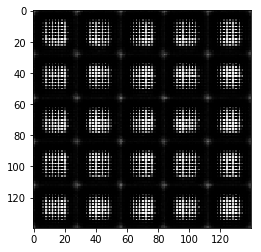

Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 5.1600
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 6.5702
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 2.1284
Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 5.0206
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 4.5835
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


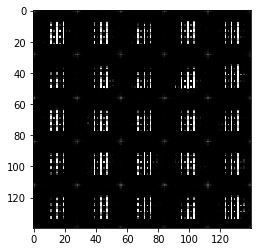

Epoch 1/2... Discriminator Loss: 0.3561... Generator Loss: 5.3938
Epoch 1/2... Discriminator Loss: 0.3561... Generator Loss: 5.1740
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 3.4747
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 2.1643
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 2.1264
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


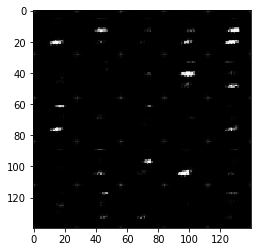

Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 1.6075
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.7138
Epoch 1/2... Discriminator Loss: 1.7311... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.7581
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.6863
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


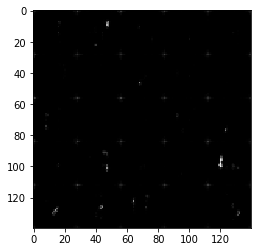

Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.6330
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.7915
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


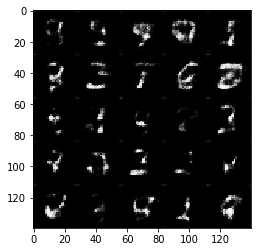

Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 1.1116
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 1.5660
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


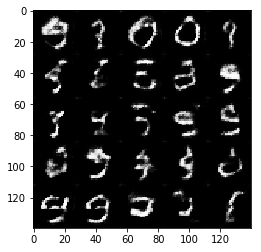

Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.5952
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.3458
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


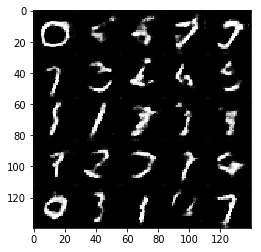

Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.4436
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.8995
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


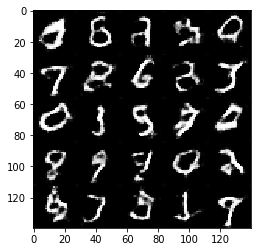

Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 1.4977... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.4989
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.1204
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.0207
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


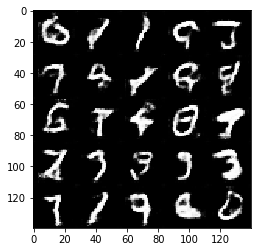

Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 1.2830
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.1242
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


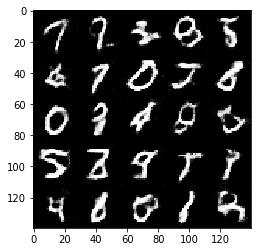

Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.6163
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.3845
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


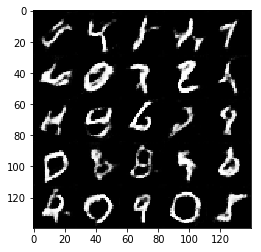

Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.2209
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.1323
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 1.0810
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


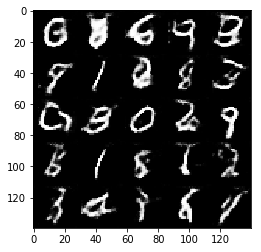

Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.2934
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 1.4697
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


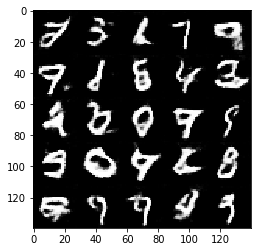

Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.7765
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


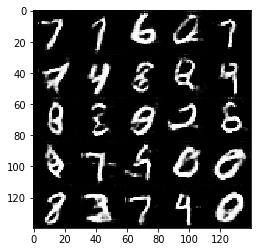

Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 1.5551
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.6749
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


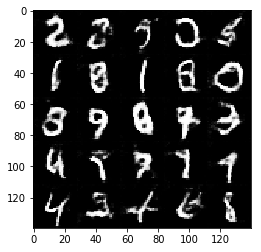

Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 1.1036
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


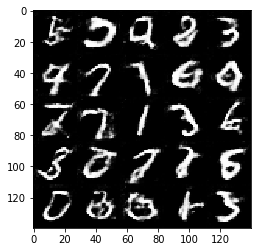

Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 1.0591
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.2617
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 1.0919
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


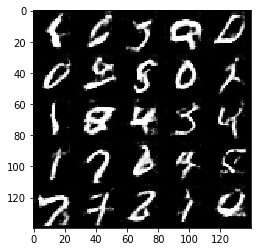

Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 1.3279
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.8637
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


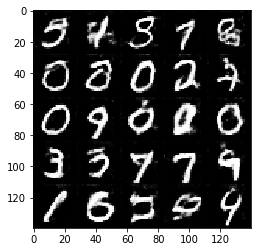

Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.6962
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


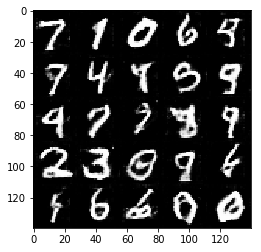

Epoch 2/2... Discriminator Loss: 1.3417... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 0.6686
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


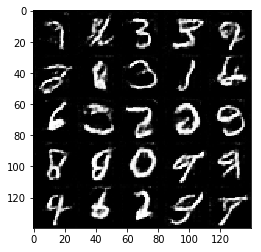

Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.9729
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.8004
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


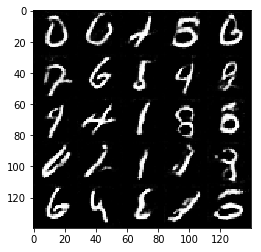

Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 1.0344
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.8017
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


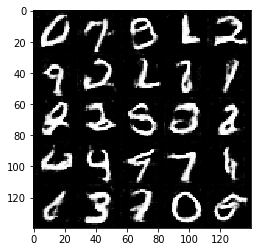

Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 1.5047
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.9400
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


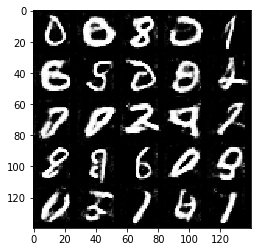

Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.8711
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


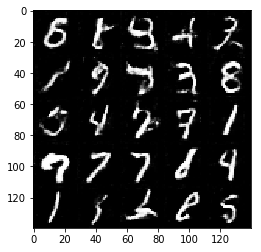

Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 1.0012
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


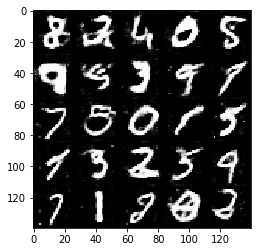

Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 1.1122
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


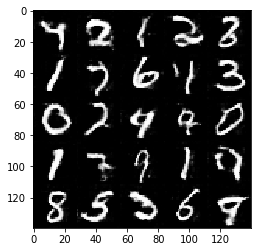

Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 1.0657
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 1.0569
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


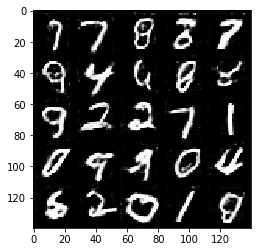

Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.9012
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


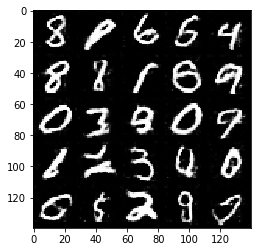

Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 1.3209
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


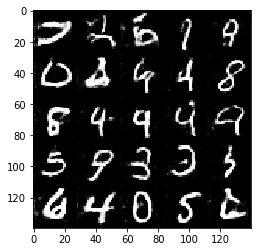

Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.9293
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.9991
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


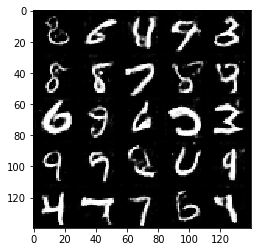

Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.8765
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.1324
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


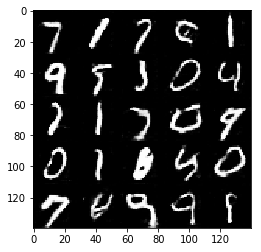

Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.8993
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


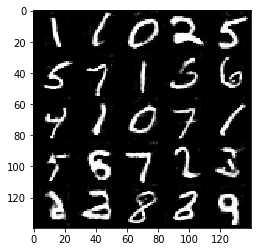

Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.1422
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


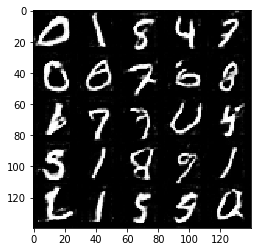

Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.3645
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


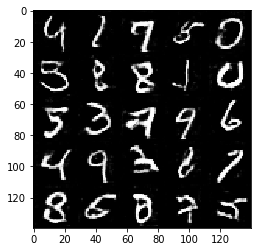

Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.5958
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 1.0039
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 1.2972
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


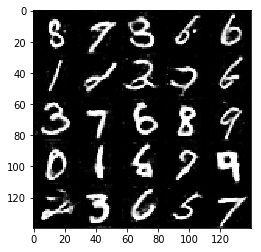

Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.2536
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


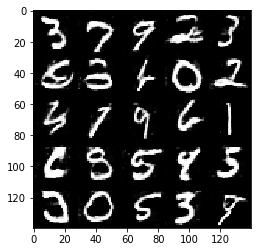

Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.8123
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


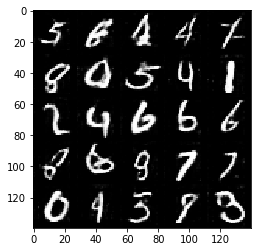

Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.6355


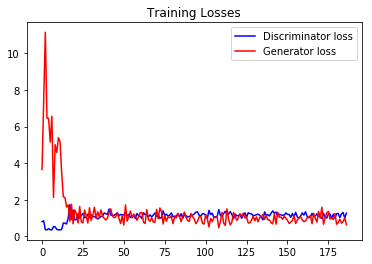

In [82]:
batch_size = 32 # Reviewer#1 Start point for experimenting on batch size would be somewhere between 16 to 32.
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5 # AdamOptimizer. Reviewer#1: Experiment with different values of beta1 between 0.2 and 0.5 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,\
                 mnist_dataset.shape, mnist_dataset.image_mode)
    
    fig, ax = plt.subplots()
    losses = np.array(losses)

    plt.plot(losses.T[0],  color='b', label='Discriminator loss')
    plt.plot(losses.T[1], color='r', label='Generator loss')
    plt.title("Training Losses")
    plt.legend()

## Plot losses 

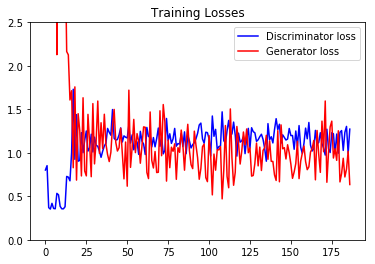

In [86]:
fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0],  color='b', label='Discriminator loss')
plt.plot(losses.T[1], color='r', label='Generator loss')
plt.title("Training Losses")
ax.set_ylim(0,2.5)
plt.legend()

In [87]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Reviewer #1

<font color='red'>  
If you want to generate varied face shapes, experiment with the value of z_dim (probably in the range 128 - 256).  
</font>  

z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 3.2659
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 2.7717
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.7997
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 6.0766
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 3.6346
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


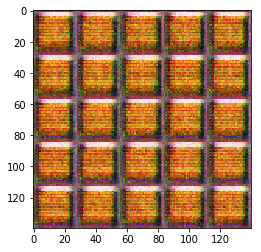

Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.5040
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 4.7619
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.9301
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 2.0623
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.4754
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


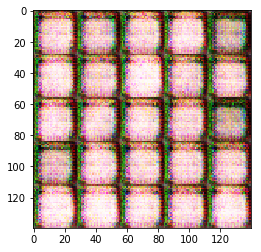

Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.3841
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.5855
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.6456
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 2.2090
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.1025
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


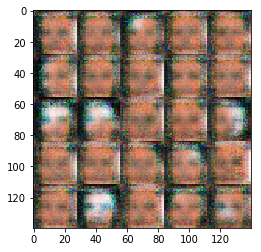

Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 3.1113
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.7123
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.1023
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.0447
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


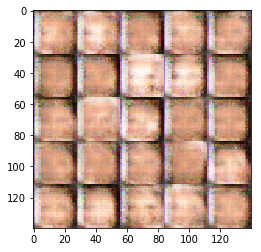

Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.6709
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.4246
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


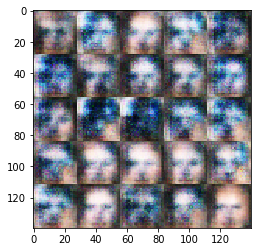

Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.7481
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.9459
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


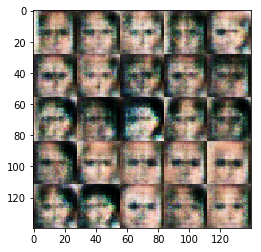

Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 2.0075
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.7127
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


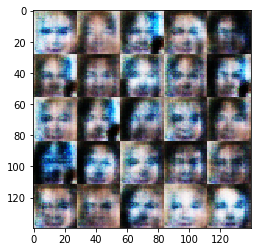

Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8882
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


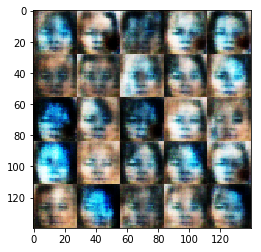

Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7992
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


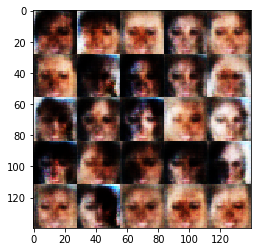

Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.9076
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.3984
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


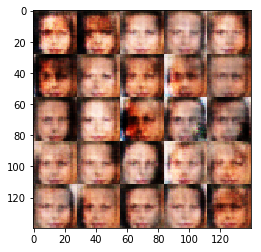

Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6839
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


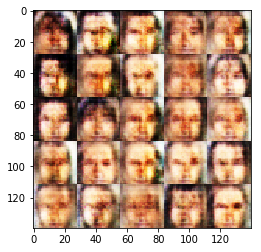

Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.4369
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0632
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


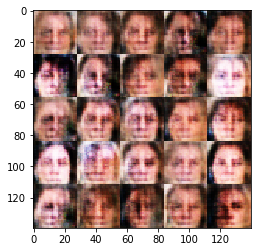

Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6192
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


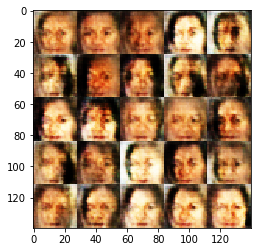

Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.4837
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.1576
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


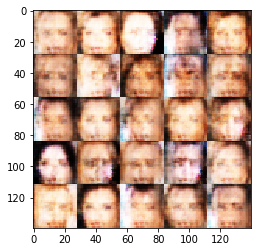

Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.7840
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7920
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


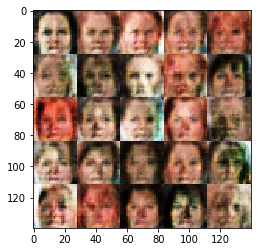

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.3532
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


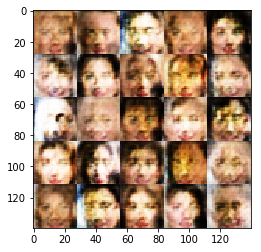

Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.9034
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


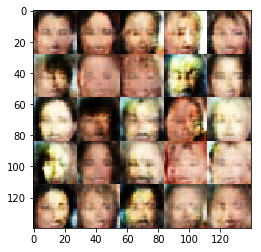

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.3352
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.1561
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


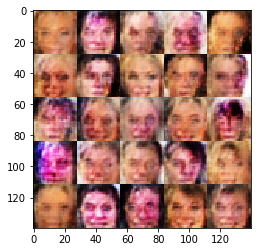

Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.4630
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


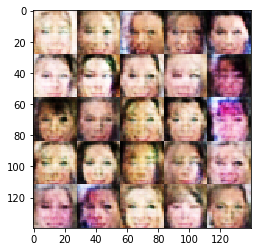

Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.2567
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


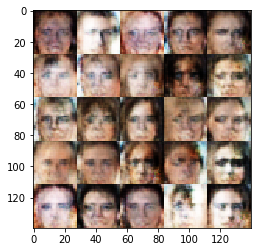

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.5803
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


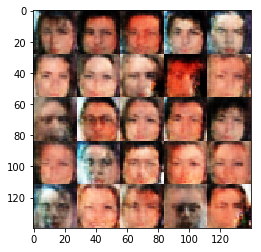

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.1456
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


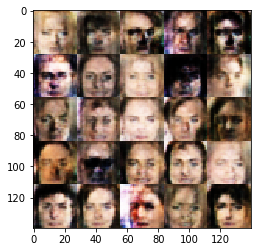

Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.1736
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


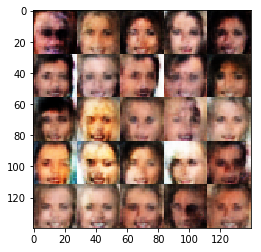

Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.5464
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


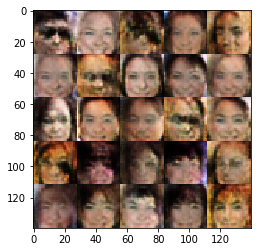

Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.7268
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


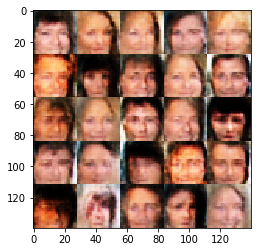

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.4265
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


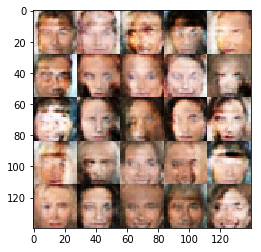

Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.2875
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


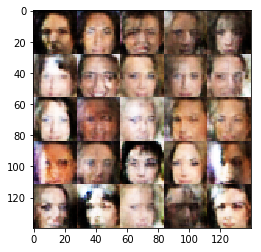

Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.5443
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


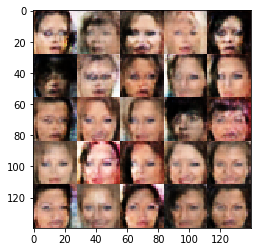

Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.3294
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


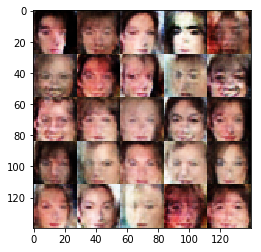

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.1489
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


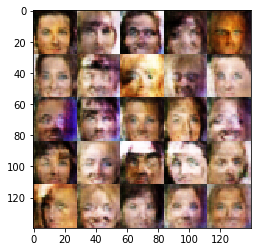

Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8418
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


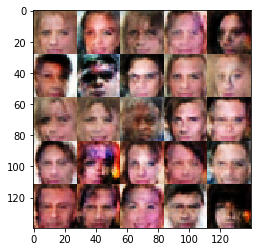

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.9306
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


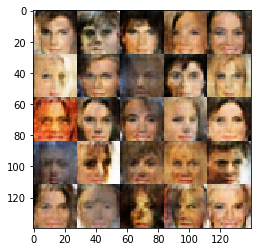

Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8039
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


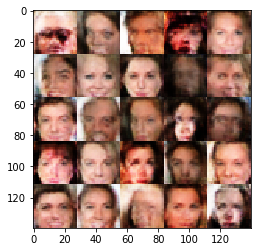

Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0804
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


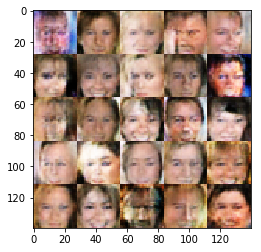

Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7816
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


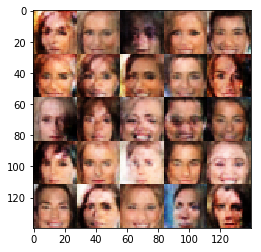

Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6465
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


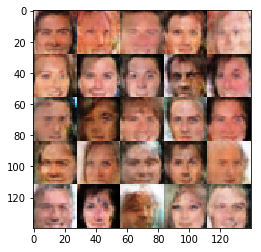

Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0751
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


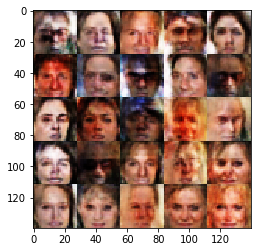

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.2042
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


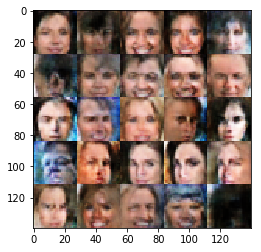

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0384
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


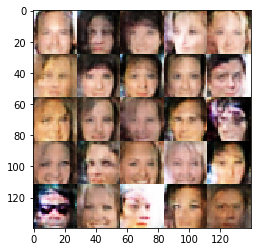

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5725
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


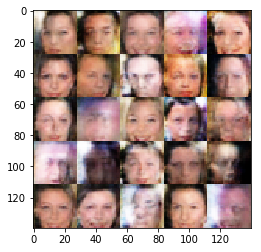

Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9046
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


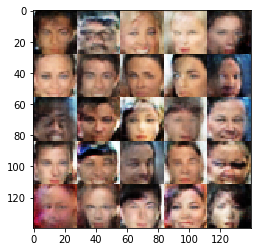

Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0505
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


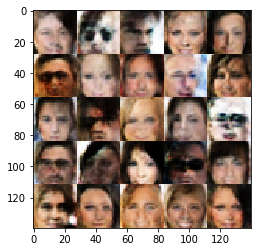

Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6367
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


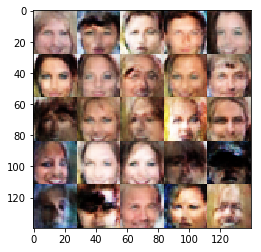

Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6863
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


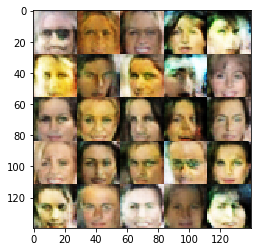

Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8450
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


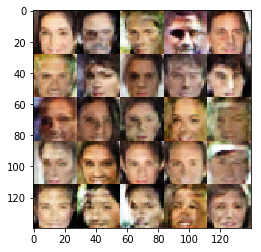

Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0588
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


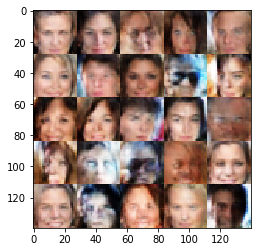

Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.1949
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


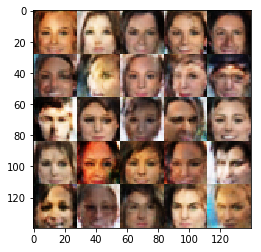

Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8898
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


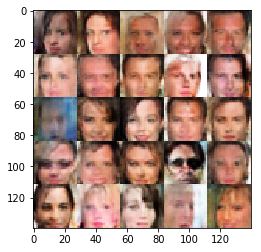

Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9126
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


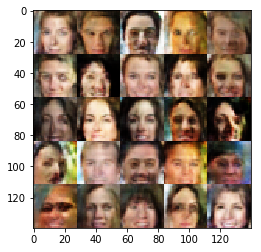

Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.3919
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


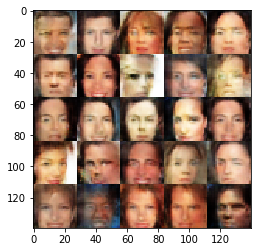

Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9445
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


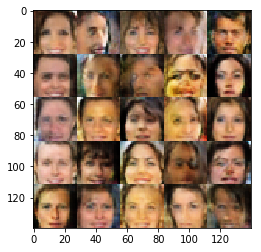

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.0877
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


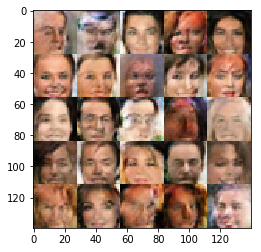

Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.0356
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


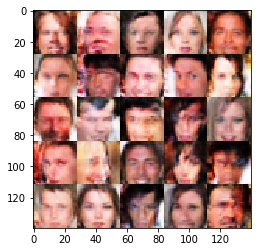

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.1434
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


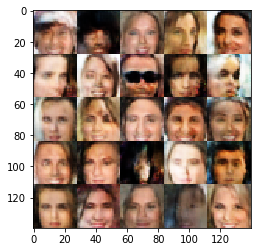

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0321
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


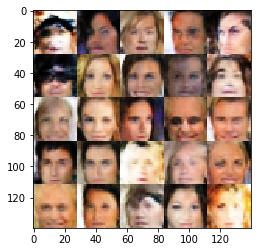

Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0480
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


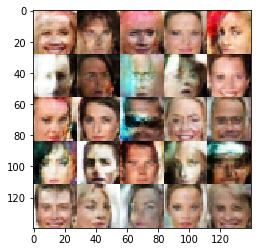

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.4131
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


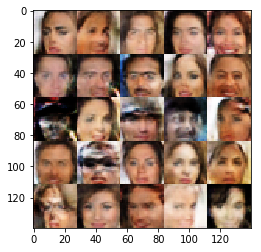

Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9921
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


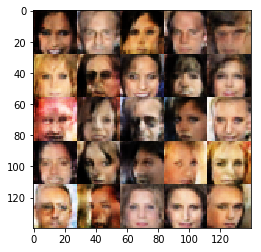

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.5397
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


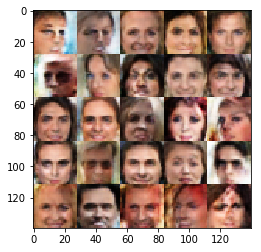

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3370
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


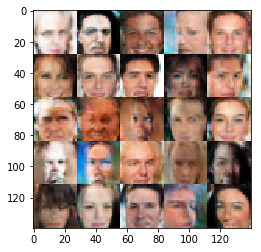

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.9131
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


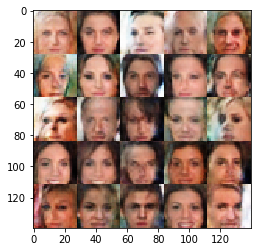

Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.3024
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


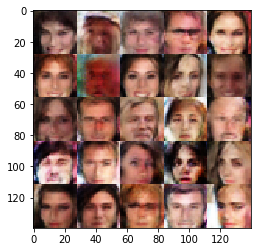

Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.0654
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


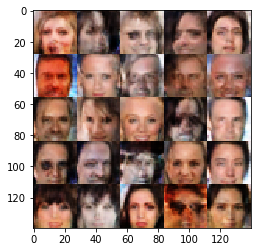

Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7204


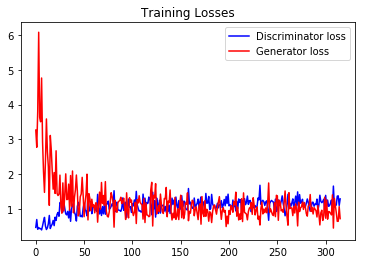

In [88]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    fig, ax = plt.subplots()
    losses = np.array(losses)

    plt.plot(losses.T[0],  color='b', label='Discriminator loss')
    plt.plot(losses.T[1], color='r', label='Generator loss')
    plt.title("Training Losses")
    plt.legend()

## Plot losses 

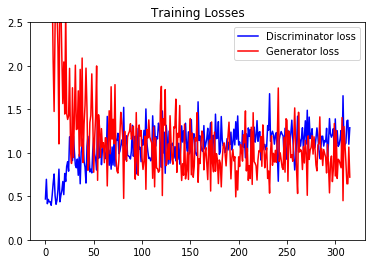

In [89]:
fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0],  color='b', label='Discriminator loss')
plt.plot(losses.T[1], color='r', label='Generator loss')
plt.title("Training Losses")
ax.set_ylim(0,2.5)
plt.legend()

In [90]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
celeba_dataset.shape

(202599, 28, 28, 3)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.